In [1]:
from torch.backends.mkl import verbose
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries


## Functions

In [2]:
## read data
def get_timeseries (filepath):
    electricity_consumption = pd.read_csv(filepath)
    # Convert dataframe to Timeseries
    ts = TimeSeries.from_dataframe(electricity_consumption, time_col="Date" )
    return ts

,Date,Total Rainfall Mm,Mean Air Temperature in Celsius,Mean Vapour Pressure Hpa,Mean Wind Speed M/Sec,Days Of Wind Gust >= 24 Knots in Day,Standard Deviation Of Daily Mean Temperature in Celsius,Year,Month,Selected business demand (GWh),Est. Total consumption (GWh)
0,2010-01-01,41.90,20.05,17.40,4.20,11.0,1.70,2010.0,1.0,572.918,282.000
1,2010-02-01,34.80,21.35,19.70,3.65,8.0,1.20,2010.0,2.0,564.809,259.792
2,2010-03-01,7.60,19.30,16.65,4.35,12.5,1.45,2010.0,3.0,621.988,295.270
3,2010-04-01,48.40,17.05,16.05,3.15,7.0,1.40,2010.0,4.0,573.259,303.576
4,2010-05-01,197.50,14.60,14.40,3.55,12.5,1.95,2010.0,5.0,608.594,363.480
...,...,...,...,...,...,...,...,...,...,...,...
169,2024-02-01,43.80,20.35,17.85,3.70,3.5,1.30,2024.0,2.0,574.002,311.724
170,2024-03-01,55.65,17.90,15.60,4.10,10.5,2.10,2024.0,3.0,581.184,337.730
171,2024-04-01,81.95,16.95,15.95,3.65,8.0,1.80,2024.0,4.0,555.174,348.859
172,2024-05-01,115.75,13.35,12.80,3.75,11.5,1.75,2024.0,5.0,593.551,452.473


In [ ]:
## preprocessing
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import shutil
from sklearn.preprocessing import MinMaxScaler

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape, mae, rmse
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

def preprocess(train_data, val_data, ts_all, electricity_type, past_feature):
    scaler = MinMaxScaler(feature_range=(0, 1))
    transformer = Scaler(scaler)
    transformer_target = Scaler(scaler)
    
    train_target_og = train_data[electricity_type]
    val_target_og = val_data[electricity_type]
    train_target_transformed = transformer_target.fit_transform(train_target_og)
    val_target_transformed = transformer_target.transform(val_target_og)
    
    # temp to avoid same name with outer scope
    train_transformed = transformer.fit_transform(train_data)
    val_transformed_temp = transformer.transform(val_data)
    series_transformed_temp = transformer.transform(ts_all)
    
    #split past covariates
    train_past_cov_temp = train_transformed[past_feature]
    
    # replace missing value with the mean of column
    train_past_cov_temp = train_past_cov_temp.pd_dataframe()
    train_past_cov_temp = train_past_cov_temp.apply(lambda col: col.fillna(col.mean()))
    
    series_transformed_temp = series_transformed_temp.pd_dataframe()
    series_transformed_temp = series_transformed_temp.apply(lambda col: col.fillna(col.mean()))
    series_transformed_temp = TimeSeries.from_dataframe(series_transformed_temp)
    return series_transformed_temp, train_past_cov_temp, train_target_transformed, val_target_transformed, val_transformed_temp

In [ ]:
def eval_model(model, transformer_target, val_target_og):
    pred_series = model.predict(n=42)
    plt.figure(figsize=(8, 5))
    pred_series_reversed = transformer_target.inverse_transform(pred_series)
    ts['Est. Total consumption (GWh)'].plot(label="actual")
    pred_series_reversed['Est. Total consumption (GWh)'].plot(label="forecast")
    if model.model_name.find("past_cov") != -1:
        plt.title("Model with past covariates: RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(rmse(val_target_og, pred_series_reversed), mae(val_target_og, pred_series_reversed), mape(val_target_og, pred_series_reversed)))
        plt.legend()
        return pred_series
    else:
        plt.title("Model without past covariates: RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(rmse(val_target_og, pred_series_reversed), mae(val_target_og, pred_series_reversed), mape(val_target_og, pred_series_reversed)))
        plt.legend()
        return pred_series

In [3]:
# read immigration data
# immigration = pd.read_csv("../immigrationData/immigration_population_type.csv")
# immigration['Date'] = pd.to_datetime(immigration['Date'], format='%Y-%m-%d')
# immigration['Date'] = immigration['Date'] - pd.offsets.MonthEnd(1) + pd.offsets.Day(1)
# electricity_consumption['Date'] = pd.to_datetime(electricity_consumption['Date'], format='%Y-%m-%d')
# electricity_consumption = electricity_consumption.merge(immigration, on='Date', how='left')


In [ ]:
res = 'Est. Total consumption (GWh)'
bus = 'Selected business demand (GWh)'

## Upper North Island - Residential

In [9]:
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [ ]:
# training and validation split
ts = get_timeseries("../AnalysisAndPreprocessing/ProcessedData/Electricity-ResBusClimateUNI.csv")
train, val = ts.split_before(pd.Timestamp('2021-01-01'))
past_cov = ['Mean Air Temperature in Celsius', 'Mean Vapour Pressure Hpa']
series_transformed, train_past_cov, train_target, val_target, val_transformed = preprocess(train, val, ts, res, past_cov)

In [48]:
# with past covariates
model_gru = BlockRNNModel(
    model="GRU",
    n_rnn_layers=3,
    hidden_dim=100,
    n_epochs=150,
    optimizer_kwargs={"lr": 1e-2},
    model_name="Electricity_GRU_with_past_cov_UNI",
    log_tensorboard=False,
    input_chunk_length=72,
    save_checkpoints=True,
    force_reset = True,
    output_chunk_length=42,
    random_state=5
)

model_gru.fit(train_target,
   past_covariates = train_past_cov,
    verbose=False)

BlockRNNModel(output_chunk_shift=0, model=GRU, hidden_dim=100, n_rnn_layers=3, hidden_fc_sizes=None, dropout=0.0, n_epochs=150, optimizer_kwargs={'lr': 0.01}, model_name=Electricity_GRU_with_past_cov, log_tensorboard=False, input_chunk_length=72, save_checkpoints=True, force_reset=True, output_chunk_length=42, random_state=5)

In [49]:
# without past covariates
model_gru_no_past_cov = BlockRNNModel(
    model="GRU",
    n_rnn_layers=3,
    hidden_dim=100,
    n_epochs=150,
    optimizer_kwargs={"lr": 1e-2},
    model_name="Electricity_GRU_no_past_cov_UNI",
    log_tensorboard=True,
    input_chunk_length=72,
    save_checkpoints=True,
    force_reset = True,
    output_chunk_length=42,
    random_state=5
)

# with past covariates
model_gru_no_past_cov.fit(train_target,
    verbose=False)

BlockRNNModel(output_chunk_shift=0, model=GRU, hidden_dim=100, n_rnn_layers=3, hidden_fc_sizes=None, dropout=0.0, n_epochs=150, optimizer_kwargs={'lr': 0.01}, model_name=Electricity_GRU, log_tensorboard=True, input_chunk_length=72, save_checkpoints=True, force_reset=True, output_chunk_length=42, random_state=5)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

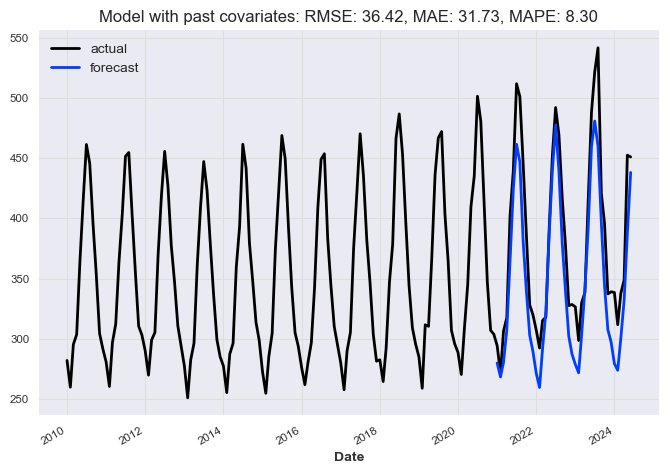

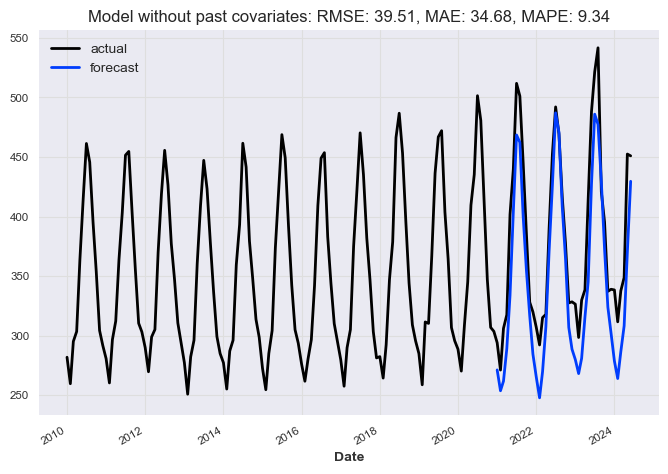

In [50]:
pred_series_transformed = eval_model(model_gru, transformer_target, val_target_og)
pred_series_transformed_no_past_cov = eval_model(model_gru_no_past_cov, transformer_target, val_target_og)

## Backtesting using 3 month forecast horizon

In [51]:
model_gru_backtest = BlockRNNModel(
    model="GRU",
    n_rnn_layers=3,
    hidden_dim=100,
    n_epochs=150,
    optimizer_kwargs={"lr": 1e-2},
    model_name="Electricity_GRU",
    log_tensorboard=True,
    input_chunk_length=66,
    save_checkpoints=True,
    force_reset = True,
    output_chunk_length=3,
    random_state=5
)

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

MAPE: 6.11%, RMSE: 30.42


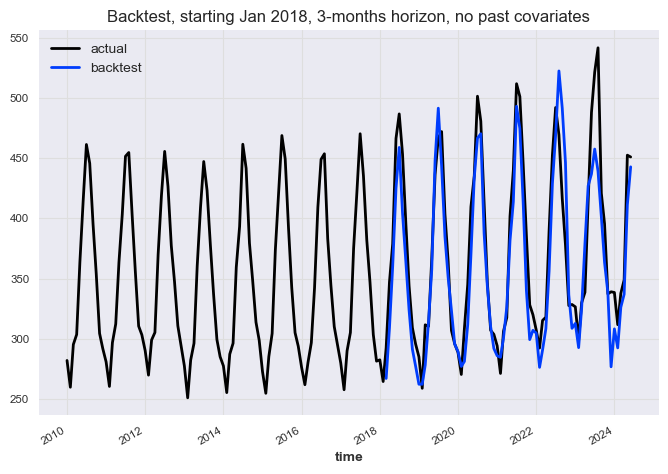

In [52]:
# without past covariates
backtest_series = model_gru_backtest.historical_forecasts(
    series_transformed['Est. Total consumption (GWh)'],
    start=pd.Timestamp("20180101"),
    forecast_horizon=3,
    retrain=True,
    verbose=False,
)

backtest_series_reversed = transformer_target.inverse_transform(backtest_series)

plt.figure(figsize=(8, 5))
ts['Est. Total consumption (GWh)'].plot(label="actual")
backtest_series_reversed.plot(label="backtest")
plt.legend()
plt.title("Backtest, starting Jan 2018, 3-months horizon, no past covariates")
print(
    "MAPE: {:.2f}%, RMSE: {:.2f}".format(
        mape(
            ts['Est. Total consumption (GWh)'],
            backtest_series_reversed,
        ),
        rmse(
            ts['Est. Total consumption (GWh)'],
            backtest_series_reversed,
        )
    )
)

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

MAPE: 5.53%, RMSE: 28.50


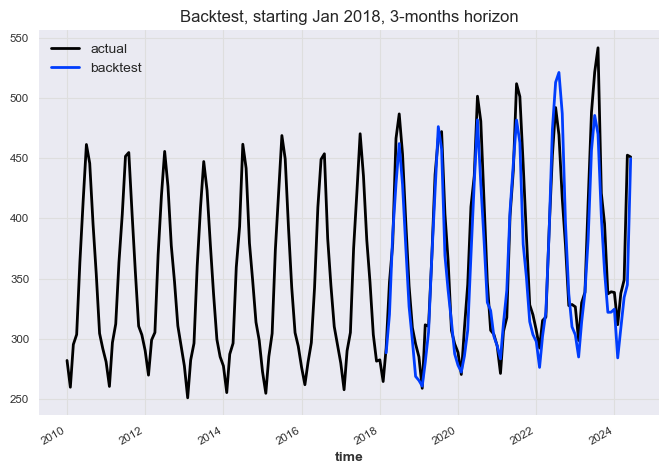

In [53]:
# with past covariates
backtest_series = model_gru_backtest.historical_forecasts(
    series_transformed['Est. Total consumption (GWh)'],
    past_covariates=series_transformed[['Mean Air Temperature in Celsius', 'Mean Vapour Pressure Hpa']],
    start=pd.Timestamp("20180101"),
    forecast_horizon=3,
    retrain=True,
    verbose=False,
)

backtest_series_reversed = transformer_target.inverse_transform(backtest_series)

plt.figure(figsize=(8, 5))
ts['Est. Total consumption (GWh)'].plot(label="actual")
backtest_series_reversed.plot(label="backtest")
plt.legend()
plt.title("Backtest, starting Jan 2018, 3-months horizon")
print(
    "MAPE: {:.2f}%, RMSE: {:.2f}".format(
        mape(
            ts['Est. Total consumption (GWh)'],
            backtest_series_reversed,
        ),
        rmse(
            ts['Est. Total consumption (GWh)'],
            backtest_series_reversed,
        )
    )
)